In [6]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, MDS
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

In [7]:
mut = pd.read_csv('TCGA.HNSC.mutations.txt', sep='\t', header=0, index_col = [0])

In [8]:
clean_mut = mut[mut['Variant_Type'] == 'SNP']
#Sigtool = clean_mut[['Hugo_Symbol', 'Chromosome', 'Start_Position', 'Reference_Allele', 'Tumor_Seq_Allele2']]
#Sigtool.to_csv('Sigtool.cvs')
clean_mut = clean_mut[['Chromosome', 'Start_Position', 'Reference_Allele', 'Tumor_Seq_Allele2', 'CONTEXT']]


In [9]:

def get_middle(sequence):
    middle_index = len(sequence) // 2
    if len(sequence) % 2 == 0:
        return sequence[middle_index - 1: middle_index + 1]
    else:
        return sequence[middle_index]
# Apply the function to the 'context' column
clean_mut['middle'] = clean_mut['CONTEXT'].apply(get_middle)


In [10]:
def reverse_complement(sequence):
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
    return ''.join(complement[base] for base in sequence[::-1])
# Apply the reverse complement function based on the condition
clean_mut['Complement'] = clean_mut['CONTEXT']
clean_mut.loc[clean_mut['middle'].isin(['G', 'A']), 'Complement'] = clean_mut.loc[clean_mut['middle'].isin(['G', 'A']), 'Complement'].apply(reverse_complement)

In [11]:
def find_middle_three(s):
    length = len(s)
    if length >= 3:
        return s[(length//2)-1:(length//2)+2]
    else:
        return s
clean_mut['Tri'] = clean_mut['Complement'].apply(find_middle_three)

In [12]:
clean_mut['Mut'] = (clean_mut['Tri'].str[0] +  "(" + clean_mut['Tri'].str[1] + ">" 
                     + clean_mut['Tumor_Seq_Allele2'].astype(str) + ')' + clean_mut['Tri'].str[2])


In [13]:
clean_mut =  clean_mut[~clean_mut['Mut'].str.contains('(C>C)')]
clean_mut = clean_mut[~clean_mut['Mut'].str.contains('(T>T)')]

In [218]:
clean_mut

,Chromosome,Start_Position,Reference_Allele,Tumor_Seq_Allele2,CONTEXT,middle,Complement,Tri,Mut
patient_id,,,,,,,,,
TCGA-4P-AA8J,10,22830863,G,A,CTCTCGCCCTC,G,GAGGGCGAGAG,GCG,G(C>A)G
TCGA-4P-AA8J,10,33495214,C,T,CATCTCTTCTT,C,CATCTCTTCTT,TCT,T(C>T)T
TCGA-4P-AA8J,10,6257188,C,T,GTGTTCAACGT,C,GTGTTCAACGT,TCA,T(C>T)A
TCGA-4P-AA8J,10,88260246,T,C,TAAAATACAGT,T,TAAAATACAGT,ATA,A(T>C)A
TCGA-4P-AA8J,11,1080567,T,C,TTCGATGGGAA,T,TTCGATGGGAA,ATG,A(T>C)G
...,...,...,...,...,...,...,...,...,...
TCGA-WA-A7H4,8,143381872,C,T,CCTCCCGCAGC,C,CCTCCCGCAGC,CCG,C(C>T)G
TCGA-WA-A7H4,8,59728263,G,A,TTCACGTCAAC,G,GTTGACGTGAA,ACG,A(C>A)G
TCGA-WA-A7H4,8,74235183,G,A,GTATCGGTTCC,G,GGAACCGATAC,CCG,C(C>A)G


In [14]:
mut_matrix = clean_mut[['Mut']]

In [15]:
mut_encoded_matrix = pd.pivot_table(mut_matrix, index='patient_id', columns='Mut', aggfunc='size', fill_value=0)

In [16]:
mut_encoded_matrix

Mut,A(C>A)A,A(C>A)C,A(C>A)G,A(C>A)T,A(C>G)A,A(C>G)C,A(C>G)G,A(C>G)T,A(C>T)A,A(C>T)C,...,T(T>A)G,T(T>A)T,T(T>C)A,T(T>C)C,T(T>C)G,T(T>C)T,T(T>G)A,T(T>G)C,T(T>G)G,T(T>G)T
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-4P-AA8J,1,0,7,1,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
TCGA-BA-4074,5,1,5,1,0,1,0,1,2,1,...,0,0,0,0,1,0,0,0,0,0
TCGA-BA-4075,3,5,3,3,0,0,0,1,1,5,...,0,1,0,0,0,1,2,0,0,2
TCGA-BA-4076,9,5,7,5,0,1,1,2,7,8,...,1,1,1,1,3,0,2,2,4,1
TCGA-BA-4077,1,1,4,0,0,0,0,0,1,1,...,0,1,0,1,0,1,0,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-UF-A7JT,4,2,2,1,1,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-UF-A7JV,0,0,1,1,0,0,0,0,2,1,...,1,1,0,1,0,0,0,0,0,0
TCGA-UP-A6WW,0,0,3,1,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,1


In [566]:
# Step 1: Convert somatic mutations into a mutational matrix M
stability_scores = []
reconstruction_errors = []
M = mut_encoded_matrix
# Your code to generate or load the mutational matrix M
# Step 2: Perform NMF with different ranks and select the optimal rank based on stability and reconstruction
# Define the range of ranks to test
rank_range = range(2, 10)  # Modify the range as needed
# Initialize variables for storing stability scores and reconstruction errors
# Perform NMF for each rank
for k in rank_range:
    # Initialize variables to store scores for this rank
    rank_stability_scores = []
    rank_reconstruction_errors = []
    # Perform multiple factorizations
    for _ in range(100):
        # Step 3: Poisson resampling and normalization
        M_resampled = np.random.poisson(M)
        M_normalized = M_resampled
        # Step 4: Perform NMF with rank k
        nmf = NMF(n_components=k, max_iter = 10000) # When init=None and n_components is less than n_samples and n_features defaults to nndsvda instead of nndsvd.
        W = nmf.fit_transform(M_normalized) #E matrix to be used for graph contribution og mutational 
        H = nmf.components_
        # Step 5: Evaluate stability using silhouette score
        labels = KMeans(n_clusters=k).fit_predict(W)
        stability_score = silhouette_score(W, labels)
        # Calculate reconstruction error (optional)
        reconstruction_error = np.linalg.norm(M_normalized - np.dot(W, H))
        # Store stability score and reconstruction error for this factorization
        rank_stability_scores.append(stability_score)
        rank_reconstruction_errors.append(reconstruction_error)
    # Calculate average stability score and reconstruction error for this rank
    average_stability_score = np.mean(rank_stability_scores)
    average_reconstruction_error = np.mean(rank_reconstruction_errors)
    # Store the average scores for this rank
    stability_scores.append(average_stability_score)
    reconstruction_errors.append(average_reconstruction_error)

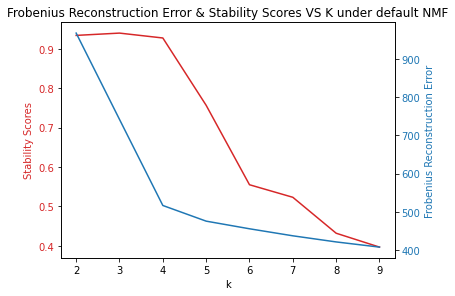

In [567]:
# Plot signature reproducibility and Frobenius reconstruction error
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('Stability Scores', color=color)
ax1.plot(range(2,10), stability_scores, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Frobenius Reconstruction Error', color=color)
ax2.plot(range(2,10), reconstruction_errors, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Frobenius Reconstruction Error & Stability Scores VS K under default NMF')
plt.show()

In [568]:
# init as random
# Step 1: Convert somatic mutations into a mutational matrix M
stability_scores = []
reconstruction_errors = []
M = mut_encoded_matrix
# Your code to generate or load the mutational matrix M
# Step 2: Perform NMF with different ranks and select the optimal rank based on stability and reconstruction
# Define the range of ranks to test
rank_range = range(2, 10)  # Modify the range as needed
# Initialize variables for storing stability scores and reconstruction errors
# Perform NMF for each rank
for k in rank_range:
    # Initialize variables to store scores for this rank
    rank_stability_scores = []
    rank_reconstruction_errors = []
    # Perform multiple factorizations
    for _ in range(100):
        # Step 3: Poisson resampling and normalization
        M_resampled = np.random.poisson(M)
        M_normalized = M_resampled
        # Step 4: Perform NMF with rank k
        nmf = NMF(n_components=k, init = "random", max_iter = 10000)
        W = nmf.fit_transform(M_normalized) #E thing to be used for graph contribution og mutational 
        H = nmf.components_
        # Step 5: Evaluate stability using silhouette score
        labels = KMeans(n_clusters=k).fit_predict(W)
        stability_score = silhouette_score(W, labels)
        # Calculate reconstruction error (optional)
        reconstruction_error = np.linalg.norm(M_normalized - np.dot(W, H))
        # Store stability score and reconstruction error for this factorization
        rank_stability_scores.append(stability_score)
        rank_reconstruction_errors.append(reconstruction_error)
    # Calculate average stability score and reconstruction error for this rank
    average_stability_score = np.mean(rank_stability_scores)
    average_reconstruction_error = np.mean(rank_reconstruction_errors)
    # Store the average scores for this rank
    stability_scores.append(average_stability_score)
    reconstruction_errors.append(average_reconstruction_error)

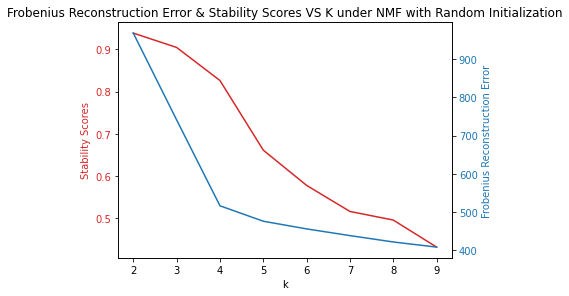

In [569]:
# Plot signature reproducibility and Frobenius reconstruction error
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('Stability Scores', color=color)
ax1.plot(range(2,10), stability_scores, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Frobenius Reconstruction Error', color=color)
ax2.plot(range(2,10), reconstruction_errors, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Frobenius Reconstruction Error & Stability Scores VS K under NMF with Random Initialization')
plt.show()

In [571]:
# init as nndsvd 
# Step 1: Convert somatic mutations into a mutational matrix M
stability_scores = []
reconstruction_errors = []
M = mut_encoded_matrix
# Your code to generate or load the mutational matrix M
# Step 2: Perform NMF with different ranks and select the optimal rank based on stability and reconstruction
# Define the range of ranks to test
rank_range = range(2, 10)  # Modify the range as needed
# Initialize variables for storing stability scores and reconstruction errors
# Perform NMF for each rank
for k in rank_range:
    # Initialize variables to store scores for this rank
    rank_stability_scores = []
    rank_reconstruction_errors = []
    # Perform multiple factorizations
    for _ in range(100):
        # Step 3: Poisson resampling and normalization
        M_resampled = np.random.poisson(M)
        M_normalized = M_resampled
        # Step 4: Perform NMF with rank k
        nmf = NMF(n_components=k, init = "nndsvd", max_iter = 10000)
        W = nmf.fit_transform(M_normalized) #E thing to be used for graph contribution og mutational 
        H = nmf.components_
        # Step 5: Evaluate stability using silhouette score
        labels = KMeans(n_clusters=k).fit_predict(W)
        stability_score = silhouette_score(W, labels)
        # Calculate reconstruction error (optional)
        reconstruction_error = np.linalg.norm(M_normalized - np.dot(W, H))
        # Store stability score and reconstruction error for this factorization
        rank_stability_scores.append(stability_score)
        rank_reconstruction_errors.append(reconstruction_error)
    # Calculate average stability score and reconstruction error for this rank
    average_stability_score = np.mean(rank_stability_scores)
    average_reconstruction_error = np.mean(rank_reconstruction_errors)
    # Store the average scores for this rank
    stability_scores.append(average_stability_score)
    reconstruction_errors.append(average_reconstruction_error)

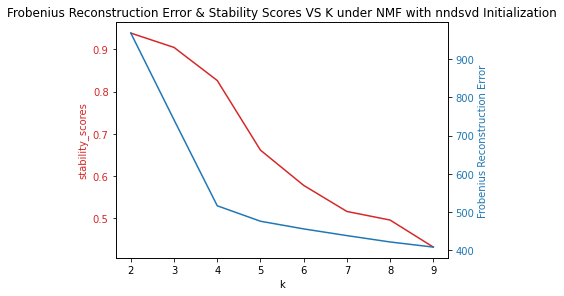

In [570]:
# Plot signature reproducibility and Frobenius reconstruction error
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('stability_scores', color=color)
ax1.plot(range(2,10), stability_scores, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Frobenius Reconstruction Error', color=color)
ax2.plot(range(2,10), reconstruction_errors, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Frobenius Reconstruction Error & Stability Scores VS K under NMF with nndsvd Initialization')
plt.show()

In [572]:
# init as nndsvda 
# Step 1: Convert somatic mutations into a mutational matrix M
stability_scores = []
reconstruction_errors = []
M = mut_encoded_matrix
# Your code to generate or load the mutational matrix M
# Step 2: Perform NMF with different ranks and select the optimal rank based on stability and reconstruction
# Define the range of ranks to test
rank_range = range(2, 10)  # Modify the range as needed
# Initialize variables for storing stability scores and reconstruction errors
# Perform NMF for each rank
for k in rank_range:
    # Initialize variables to store scores for this rank
    rank_stability_scores = []
    rank_reconstruction_errors = []
    # Perform multiple factorizations
    for _ in range(100):
        # Step 3: Poisson resampling and normalization
        M_resampled = np.random.poisson(M)
        M_normalized = M_resampled
        # Step 4: Perform NMF with rank k
        nmf = NMF(n_components=k, init = "nndsvda", max_iter = 10000)
        W = nmf.fit_transform(M_normalized) #E thing to be used for graph contribution og mutational 
        H = nmf.components_
        # Step 5: Evaluate stability using silhouette score
        labels = KMeans(n_clusters=k).fit_predict(W)
        stability_score = silhouette_score(W, labels)
        # Calculate reconstruction error (optional)
        reconstruction_error = np.linalg.norm(M_normalized - np.dot(W, H))
        # Store stability score and reconstruction error for this factorization
        rank_stability_scores.append(stability_score)
        rank_reconstruction_errors.append(reconstruction_error)
    # Calculate average stability score and reconstruction error for this rank
    average_stability_score = np.mean(rank_stability_scores)
    average_reconstruction_error = np.mean(rank_reconstruction_errors)
    # Store the average scores for this rank
    stability_scores.append(average_stability_score)
    reconstruction_errors.append(average_reconstruction_error)

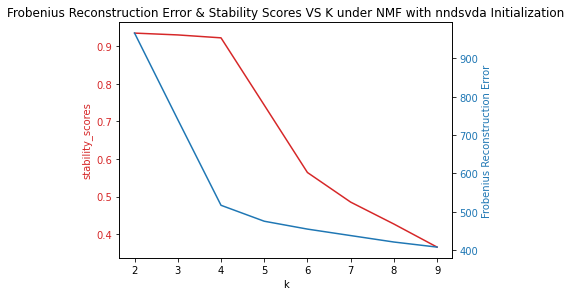

In [573]:
# Plot signature reproducibility and Frobenius reconstruction error
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('stability_scores', color=color)
ax1.plot(range(2,10), stability_scores, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Frobenius Reconstruction Error', color=color)
ax2.plot(range(2,10), reconstruction_errors, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Frobenius Reconstruction Error & Stability Scores VS K under NMF with nndsvda Initialization')
plt.show()

In [591]:
# change solver from cd to Mu
# Step 1: Convert somatic mutations into a mutational matrix M
stability_scores = []
reconstruction_errors = []
M = mut_encoded_matrix
# Your code to generate or load the mutational matrix M
# Step 2: Perform NMF with different ranks and select the optimal rank based on stability and reconstruction
# Define the range of ranks to test
rank_range = range(2, 10)  # Modify the range as needed
# Initialize variables for storing stability scores and reconstruction errors
# Perform NMF for each rank
for k in rank_range:
    # Initialize variables to store scores for this rank
    rank_stability_scores = []
    rank_reconstruction_errors = []
    # Perform multiple factorizations
    for _ in range(100):
        # Step 3: Poisson resampling and normalization
        M_resampled = np.random.poisson(M)
        M_normalized = M_resampled
        # Step 4: Perform NMF with rank k
        nmf = NMF(n_components=k, solver = 'mu', max_iter = 10000) # When init=None and n_components is less than n_samples and n_features defaults to nndsvda instead of nndsvd.
        W = nmf.fit_transform(M_normalized) #E matrix to be used for graph contribution og mutational 
        H = nmf.components_
        # Step 5: Evaluate stability using silhouette score
        labels = KMeans(n_clusters=k).fit_predict(W)
        stability_score = silhouette_score(W, labels)
        # Calculate reconstruction error (optional)
        reconstruction_error = np.linalg.norm(M_normalized - np.dot(W, H))
        # Store stability score and reconstruction error for this factorization
        rank_stability_scores.append(stability_score)
        rank_reconstruction_errors.append(reconstruction_error)
    # Calculate average stability score and reconstruction error for this rank
    average_stability_score = np.mean(rank_stability_scores)
    average_reconstruction_error = np.mean(rank_reconstruction_errors)
    # Store the average scores for this rank
    stability_scores.append(average_stability_score)
    reconstruction_errors.append(average_reconstruction_error)

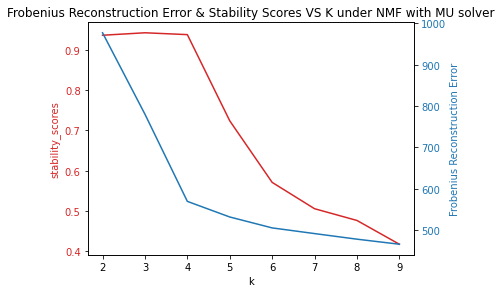

In [593]:
# Plot signature reproducibility and Frobenius reconstruction error
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('stability_scores', color=color)
ax1.plot(range(2,10), stability_scores, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Frobenius Reconstruction Error', color=color)
ax2.plot(range(2,10), reconstruction_errors, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Frobenius Reconstruction Error & Stability Scores VS K under NMF with MU solver')
plt.show()

In [601]:
# change beta loss from frobenius to kullback-leibler
# Step 1: Convert somatic mutations into a mutational matrix M
stability_scores = []
reconstruction_errors = []
M = mut_encoded_matrix
# Your code to generate or load the mutational matrix M
# Step 2: Perform NMF with different ranks and select the optimal rank based on stability and reconstruction
# Define the range of ranks to test
rank_range = range(2, 10)  # Modify the range as needed
# Initialize variables for storing stability scores and reconstruction errors
# Perform NMF for each rank
for k in rank_range:
    # Initialize variables to store scores for this rank
    rank_stability_scores = []
    rank_reconstruction_errors = []
    # Perform multiple factorizations
    for _ in range(100):
        # Step 3: Poisson resampling and normalization
        M_resampled = np.random.poisson(M)
        M_normalized = M_resampled
        # Step 4: Perform NMF with rank k
        nmf = NMF(n_components=k, solver = 'mu', beta_loss = 'kullback-leibler', max_iter = 10000) # When init=None and n_components is less than n_samples and n_features defaults to nndsvda instead of nndsvd.
        W = nmf.fit_transform(M_normalized) #E matrix to be used for graph contribution og mutational 
        H = nmf.components_
        # Step 5: Evaluate stability using silhouette score
        labels = KMeans(n_clusters=k).fit_predict(W)
        stability_score = silhouette_score(W, labels)
        # Calculate reconstruction error (optional)
        reconstruction_error = np.linalg.norm(M_normalized - np.dot(W, H))
        # Store stability score and reconstruction error for this factorization
        rank_stability_scores.append(stability_score)
        rank_reconstruction_errors.append(reconstruction_error)
    # Calculate average stability score and reconstruction error for this rank
    average_stability_score = np.mean(rank_stability_scores)
    average_reconstruction_error = np.mean(rank_reconstruction_errors)
    # Store the average scores for this rank
    stability_scores.append(average_stability_score)
    reconstruction_errors.append(average_reconstruction_error)

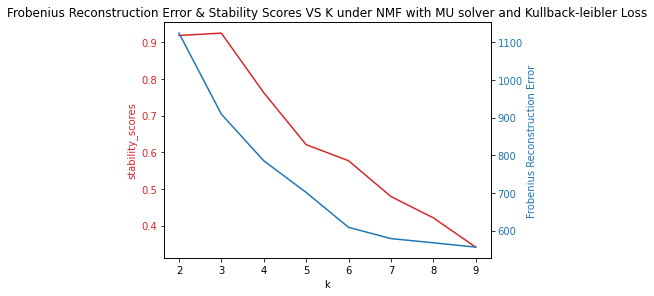

In [602]:
# Plot signature reproducibility and Frobenius reconstruction error
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('stability_scores', color=color)
ax1.plot(range(2,10), stability_scores, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Frobenius Reconstruction Error', color=color)
ax2.plot(range(2,10), reconstruction_errors, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Frobenius Reconstruction Error & Stability Scores VS K under NMF with MU solver and Kullback-leibler Loss')
plt.show()

In [17]:
# k = 5
M = mut_encoded_matrix
nmf = NMF(n_components=5)
W = nmf.fit_transform(M)  
H = nmf.components_  

In [610]:
signitures = pd.DataFrame(H)
signitures.columns =  mut_encoded_matrix.columns
signitures

Mut,A(C>A)A,A(C>A)C,A(C>A)G,A(C>A)T,A(C>G)A,A(C>G)C,A(C>G)G,A(C>G)T,A(C>T)A,A(C>T)C,...,T(T>A)G,T(T>A)T,T(T>C)A,T(T>C)C,T(T>C)G,T(T>C)T,T(T>G)A,T(T>G)C,T(T>G)G,T(T>G)T
0,0.158951,2.603270,0.139844,0.575281,0.034479,0.059812,0.034888,0.000000,0.291075,2.190358,...,0.049258,0.292969,0.181692,0.059768,0.206176,0.143376,0.213553,0.063657,0.240822,0.183167
1,0.196941,0.102303,0.822965,0.115222,0.109546,0.117814,0.029918,0.192129,0.145499,0.104210,...,0.000000,0.057698,0.000000,0.045579,0.003571,0.032181,0.000000,0.072220,0.019996,0.014094
2,0.466959,0.000000,0.089977,0.497135,0.000603,0.003399,0.002238,0.000000,0.946526,0.120201,...,0.002099,0.027164,0.000000,0.051935,0.019670,0.023100,0.000000,0.000000,0.098003,0.037351
3,0.767515,0.749954,4.663944,0.702709,0.053041,0.104928,0.000000,0.028655,0.815037,0.676571,...,0.000000,0.095935,1.942665,2.071537,1.446273,1.577390,1.320363,1.258775,1.179528,1.668400
4,3.321430,2.692051,4.306795,1.782016,0.863711,0.635627,0.448756,0.664859,3.320758,2.841335,...,0.469978,0.312552,0.548217,0.462888,0.595182,0.573364,0.434272,0.414332,0.817586,0.585801


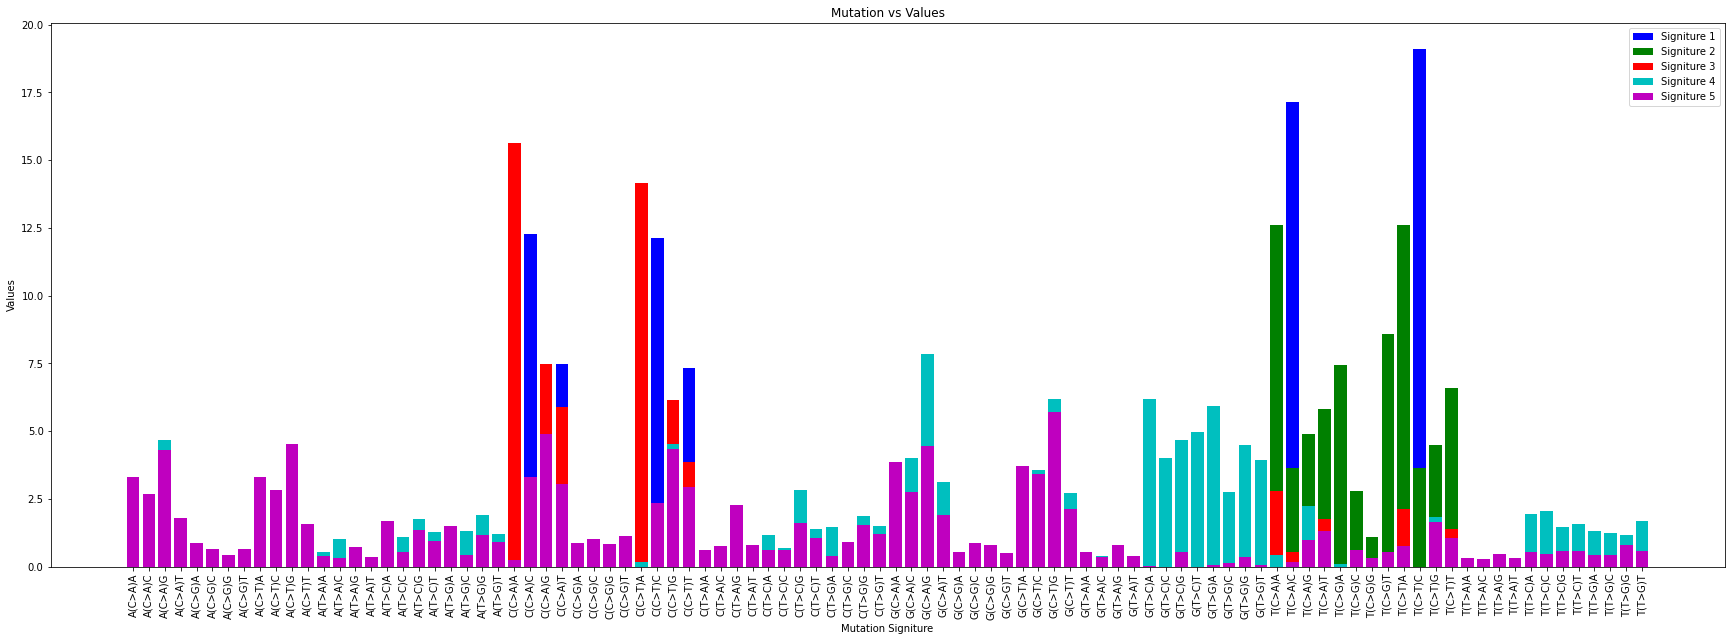

In [611]:
colors = ['b', 'g', 'r', 'c', 'm']
plt.figure(figsize=(30, 10))
for i in range(signitures.shape[0]):
    plt.bar(signitures.columns, signitures.iloc[i, :], color=colors[i % len(colors)], label=f'Signiture {i+1}')
plt.xlabel('Mutation Signiture')
plt.ylabel('Values')
plt.title('Mutation vs Values')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [18]:
W_data = pd.DataFrame(W)
W_data.columns = ['Signiture1', 'Signiture2', 'Signiture3', 'Signiture4','Signiture5']
W_data.head()

,Signiture1,Signiture2,Signiture3,Signiture4,Signiture5
0,0.153056,0.566102,0.000000,0.207363,0.275048
1,0.149511,0.190536,0.246391,0.106089,0.705438
2,0.270575,0.258609,0.204927,0.036008,0.801023
3,0.268473,0.497586,0.522653,0.021515,1.759548
4,0.042429,3.109298,0.000000,0.000883,0.320608


In [19]:
metadata = pd.read_csv('TCGA.HNSC.metadata.txt', sep='\t', header=0)
metadata = metadata[["age_at_initial_pathologic_diagnosis", "gender", "race", "ajcc_pathologic_tumor_stage", "tumor_status"]]
metadata

,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,tumor_status
0,66.0,MALE,BLACK OR AFRICAN AMERICAN,Stage IVA,TUMOR FREE
1,69.0,MALE,WHITE,Stage IVA,WITH TUMOR
2,49.0,MALE,BLACK OR AFRICAN AMERICAN,Stage III,WITH TUMOR
3,39.0,MALE,WHITE,[Not Available],WITH TUMOR
4,45.0,FEMALE,WHITE,Stage IVA,WITH TUMOR
...,...,...,...,...,...
495,72.0,FEMALE,WHITE,Stage IVA,WITH TUMOR
496,62.0,FEMALE,WHITE,Stage IVA,WITH TUMOR
497,58.0,MALE,WHITE,[Not Available],TUMOR FREE
498,58.0,MALE,WHITE,[Not Available],TUMOR FREE


In [20]:
full_data = pd.concat([metadata, W_data], axis=1, join='inner')
#data cleaning
race_lis = ['BLACK OR AFRICAN AMERICAN','WHITE','ASIAN', 'AMERICAN INDIAN OR ALASKA NATIVE']
full_data = full_data[full_data['race'].isin(race_lis)]
full_data = full_data[full_data['ajcc_pathologic_tumor_stage'] != '[Not Available]']
full_data

,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,tumor_status,Signiture1,Signiture2,Signiture3,Signiture4,Signiture5
0,66.0,MALE,BLACK OR AFRICAN AMERICAN,Stage IVA,TUMOR FREE,0.153056,0.566102,0.000000,0.207363,0.275048
1,69.0,MALE,WHITE,Stage IVA,WITH TUMOR,0.149511,0.190536,0.246391,0.106089,0.705438
2,49.0,MALE,BLACK OR AFRICAN AMERICAN,Stage III,WITH TUMOR,0.270575,0.258609,0.204927,0.036008,0.801023
4,45.0,FEMALE,WHITE,Stage IVA,WITH TUMOR,0.042429,3.109298,0.000000,0.000883,0.320608
6,47.0,MALE,WHITE,Stage IVA,WITH TUMOR,0.026367,0.392063,0.009880,0.151867,0.546862
...,...,...,...,...,...,...,...,...,...,...
493,79.0,FEMALE,WHITE,Stage IVA,WITH TUMOR,0.000000,1.008505,0.093211,0.280659,0.815939
494,59.0,MALE,WHITE,Stage IVA,WITH TUMOR,0.000000,0.209442,0.106353,0.131931,0.252012
495,72.0,FEMALE,WHITE,Stage IVA,WITH TUMOR,0.133564,1.148337,0.305439,0.138724,0.524452
496,62.0,FEMALE,WHITE,Stage IVA,WITH TUMOR,0.000000,0.598164,0.046398,0.000000,0.206438


In [21]:
# T-test
from scipy.stats import ttest_ind
#race 
group1 = full_data[full_data['gender']=='MALE']
group2 = full_data[full_data['gender']=='FEMALE']
for i in W_data.columns:
    #perform independent two sample t-test
    t_stat, p_val = ttest_ind(group1[i], group2[i])
    print("T-Test Result P value of " + i + " : " +  str(p_val))

T-Test Result P value of Signiture1 : 0.4496842296226464
T-Test Result P value of Signiture2 : 0.4124342459710917
T-Test Result P value of Signiture3 : 0.692010914755069
T-Test Result P value of Signiture4 : 0.614776580845458
T-Test Result P value of Signiture5 : 0.7411561417405186


In [23]:
# Anova Test
import scipy.stats as stats
group1 = full_data[full_data['race']=='BLACK OR AFRICAN AMERICAN']
group2 = full_data[full_data['race']=='WHITE']
group3 = full_data[full_data['race']=='ASIAN']
group4 = full_data[full_data['race']=='AMERICAN INDIAN OR ALASKA NATIVE']
for i in W_data.columns:
    #perform independent two sample t-test
    f_stat, p_val = stats.f_oneway(group1[i], group2[i], group3[i], group4[i])
    print('ANOVA Result P value for race ' + i + " : " + str(p_val))

ANOVA Result P value for race Signiture1 : 0.9723159697863171
ANOVA Result P value for race Signiture2 : 0.8020901669866612
ANOVA Result P value for race Signiture3 : 0.9397915576472509
ANOVA Result P value for race Signiture4 : 0.9904191236936165
ANOVA Result P value for race Signiture5 : 0.6469407624996273


In [38]:
# OLS regression
from statsmodels.formula.api import ols
import statsmodels.api as sm
import patsy
outcome, predictors = patsy.dmatrices('Signiture1 ~ ajcc_pathologic_tumor_stage', data = full_data)
mod = sm.OLS(outcome, predictors)
res = mod.fit() 
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             Signiture1   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8965
Date:                Fri, 19 May 2023   Prob (F-statistic):              0.497
Time:                        01:58:58   Log-Likelihood:                -713.41
No. Observations:                 421   AIC:                             1441.
Df Residuals:                     414   BIC:                             1469.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [43]:
# find correlation between two numeric data age and W from signiture
for i in W_data.columns:
    correlation, p_val = stats.pearsonr(full_data['age_at_initial_pathologic_diagnosis'], full_data[i])
    print('Pearson P-value for ' + i + ' : ', p_val)

Pearson P-value for Signiture1 :  0.8360874863855382
Pearson P-value for Signiture2 :  0.021408591022410564
Pearson P-value for Signiture3 :  0.5602378488974729
Pearson P-value for Signiture4 :  0.19343827432541788
Pearson P-value for Signiture5 :  0.07898058476461702
